In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg
import numpy as np

# Connect to the PostgreSQL database
conn = psycopg.connect(
    host="localhost",
    user="postgres",        # Change to your PostgreSQL username
    password="0210",       # Change to your PostgreSQL password
    dbname="ecommerce"     # Change to your database name
)

# Create a cursor object to interact with the database
cur = conn.cursor()

List all unique cities where customers are located

In [29]:
query = ''' select distinct customer_city from customers '''
cur.execute(query)
data = cur.fetchall()
data

[('bom jardim de minas',),
 ('alto rio doce',),
 ('alvorada do gurgueia',),
 ('batatais',),
 ('capao da porteira',),
 ('icatu',),
 ('osorio',),
 ('populina',),
 ('novo mundo',),
 ('tururu',),
 ("alta floresta d'oeste",),
 ('cajamar',),
 ('presidente lucena',),
 ('santa maria do salto',),
 ('cacador',),
 ('araxa',),
 ('carnaubais',),
 ('lindolfo collor',),
 ('japira',),
 ('botelho',),
 ('tabapua',),
 ('joao camara',),
 ('barrolandia',),
 ('nepomuceno',),
 ('ibertioga',),
 ('frei lagonegro',),
 ('sao jose da barra',),
 ('pitangui',),
 ('jaragua do sul',),
 ('ervalia',),
 ('governador celso ramos',),
 ('santa ernestina',),
 ('quatro bocas',),
 ('grao mogol',),
 ('diamantina',),
 ('itaju',),
 ('tiradentes',),
 ('junqueiro',),
 ('macambira',),
 ('barauna',),
 ('ibirapua',),
 ('uniao do sul',),
 ('palma',),
 ('agrolandia',),
 ('bom jesus da serra',),
 ('surubim',),
 ('unai',),
 ('formosa do rio preto',),
 ('medianeira',),
 ('japoata',),
 ('emilianopolis',),
 ('lupionopolis',),
 ('ivai',),
 (

Count the number of orders placed in 2017

In [30]:
query = ''' SELECT COUNT(order_id)
            FROM orders
            WHERE EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) = 2017 '''
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 45101)

Total sales per category

In [31]:
query = ''' select
	            products.product_category,
	            round(sum(payments.payment_value)::numeric, 2) as sales
            from products
            join order_items
	            on products.product_id = order_items.product_id
            join payments
	            on order_items.order_id = payments.order_id
            group by products.product_category '''
cur.execute(query)
data = cur.fetchall()
sales_category = pd.DataFrame(data, columns=['product_category', 'sales'])
sales_category

,product_category,sales
0,Agro Industria e Comercio,118730.61
1,Art,30992.93
2,Arts and Crafts,2326.17
3,audio,60324.62
4,automotive,852294.33
...,...,...
69,technical books,24915.44
70,telephony,486882.05
71,toys,619037.69
72,Watches present,1429216.68


Percentage of orders that were paid in installments.

In [32]:
query = ''' select
	        100.0 * sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)
            from payments; '''
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9980748127755424')

The number of customers from each state

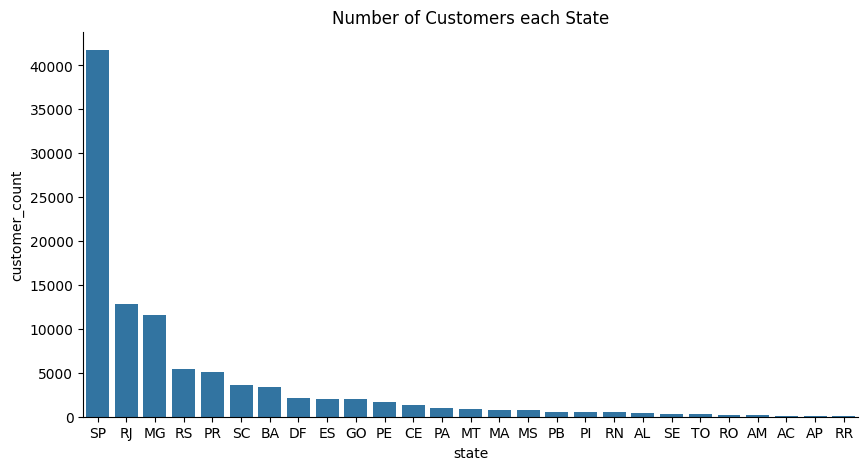

In [33]:
query = ''' select
	            customer_state, count(customer_id)
            from customers
            group by customer_state '''
cur.execute(query)
data = cur.fetchall()
customercount_eachstate = pd.DataFrame(data, columns=['state', 'customer_count'])
customercount_eachstate = customercount_eachstate.sort_values(by='customer_count', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(customercount_eachstate, x='state', y='customer_count')
plt.title("Number of Customers each State")
sns.despine()
plt.show()

Calculate the number of orders per month in 2018

In [34]:
query = ''' SELECT
                TO_CHAR(TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'), 'Month') AS order_month,
                COUNT(order_id) AS order_count
            FROM orders
            WHERE EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) = 2018
            GROUP BY TO_CHAR(TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'), 'Month') '''
cur.execute(query)
data = cur.fetchall()
orders_2018 = pd.DataFrame(data, columns=['month', 'order_count'])
orders_2018['month'] = orders_2018['month'].str.strip()
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
orders_2018

,month,order_count
0,April,6939
1,August,6512
2,February,6728
3,January,7269
4,July,6292
5,June,6167
6,March,7211
7,May,6873
8,October,4
9,September,16


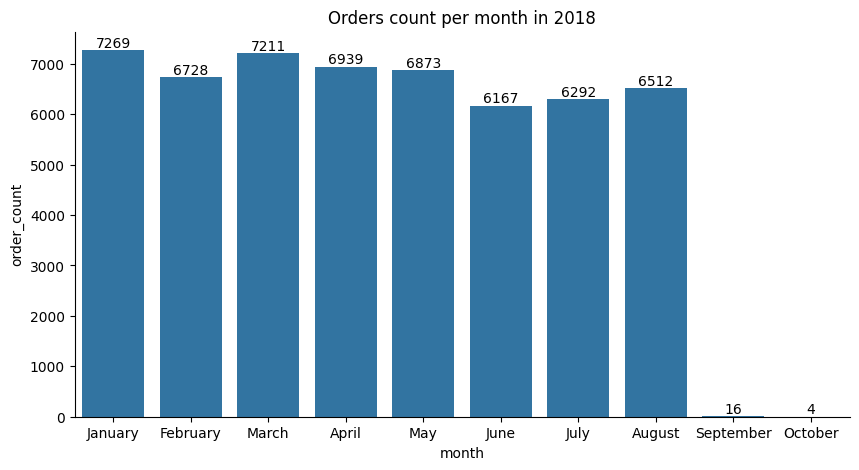

In [35]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=orders_2018, x='month', y='order_count', order=month_order)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Orders count per month in 2018")
sns.despine()

Average number of products per order, grouped by customer city

In [36]:
query = ''' with order_count as (
	            select
		            orders.order_id,
		            orders.customer_id,
		            count(order_items.order_id) as order_count
	            from orders 
	            join order_items
		        on orders.order_id = order_items.order_id
	            group by orders.order_id, orders.customer_id
            )
            select
	            customers.customer_city,
	            round(avg(order_count.order_count), 2) as avg_order
            from customers
            join order_count
	        on order_count.customer_id = customers.customer_id
            group by customers.customer_city '''
cur.execute(query)
data = cur.fetchall()
avg_order_city = pd.DataFrame(data, columns=['city', 'avg_product'])
avg_order_city = avg_order_city.sort_values(by='avg_product', ascending=False)
avg_order_city

,city,avg_product
279,padre carvalho,7.00
3976,celso ramos,6.50
1196,datas,6.00
3799,candido godoi,6.00
1602,matias olimpio,5.00
...,...,...
1681,lagarto,1.00
1682,mansidao,1.00
1683,piracema,1.00
1684,ipueira,1.00


Percentage of total revenue contributed by each product category

In [37]:
query = ''' select
	            products.product_category,
	            round((100*sum(payments.payment_value)/(select sum(payment_value) from payments))::numeric, 2) as sales_percentage
            from products
            join order_items
                on products.product_id = order_items.product_id
            join payments
                on order_items.order_id = payments.order_id
            group by products.product_category
            order by sales_percentage desc '''
cur.execute(query)
data = cur.fetchall()
revenue_percentage_category = pd.DataFrame(data, columns=['product_category', 'sales_percentage'])
revenue_percentage_category

,product_category,sales_percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,flowers,0.01
71,Arts and Crafts,0.01
72,Fashion Children's Clothing,0.00


Identify the correlation between product price and the number of times a product has been purchased.

In [38]:
query = ''' select
	            products.product_category,
	            count(order_items.order_id),
	            avg(order_items.price)
            from products
            join order_items
	            on products.product_id = order_items.product_id
            group by products.product_category '''
cur.execute(query)
data = cur.fetchall()

In [39]:
corr_df = pd.DataFrame(data, columns=['product_category', 'order_count', 'avg_price'])
corr_df

,product_category,order_count,avg_price
0,Agro Industria e Comercio,212,342.124858
1,Art,209,115.802105
2,Arts and Crafts,24,75.583750
3,audio,364,139.254121
4,automotive,4235,139.957523
...,...,...,...
69,technical books,267,71.520824
70,telephony,4545,71.213978
71,toys,4117,117.548360
72,Watches present,5991,201.135984


In [40]:
arr1 = corr_df['order_count']
arr2 = corr_df['avg_price']
np.corrcoef([arr1, arr2])

array([[ 1.        , -0.10631552],
       [-0.10631552,  1.        ]])

Calculate the total revenue generated by each seller, and rank them by revenue.

In [41]:
query = ''' with revenue as (
	            select
		            sellers.seller_id,
		            round(sum(payment_value)::numeric, 2) as revenue
	            from sellers
	            join order_items
		            on sellers.seller_id = order_items.seller_id
	            join payments
		            on order_items.order_id = payments.order_id
	            group by sellers.seller_id
            )
            select
	            *,
	            row_number() over(order by revenue desc) as rank_seller
            from revenue '''
cur.execute(query)
data = cur.fetchall()

In [42]:
seller_revenue_rank = pd.DataFrame(data, columns=['seller_id', 'revenue', 'seller_rank'])
seller_revenue_rank

,seller_id,revenue,seller_rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3091
3091,702835e4b785b67a084280efca355756,18.56,3092
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3093
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3094


Calculate the moving average of order values for each customer over their order history.

In [43]:
query = ''' with paymentvalue as (
	            select
		            orders.customer_id,
		            orders.order_purchase_timestamp,
		            payments.payment_value
	            from orders
	            join payments
		            on orders.order_id = payments.order_id
            )
            select
	            customer_id,
	            order_purchase_timestamp,
	            payment_value,
	            avg(payment_value) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
            from paymentvalue '''
cur.execute(query)
data = cur.fetchall()

In [44]:
moving_avg = pd.DataFrame(data, columns = ['customer_id', 'timestamp', 'payment_value', 'mov_avg'])
moving_avg

,customer_id,timestamp,payment_value,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


Calculate the cumulative sales per month for each year.

In [45]:
query = ''' with sales_per_month as (
	            select
		            EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) as year,
		            EXTRACT(Month FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) as month,
		            sum(payment_value) as sales_month
	            from orders o
	            join payments p
		            on o.order_id = p.order_id
	            group by EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')),
			             EXTRACT(Month FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'))
            )
            select
	            year, month, round(sales_month::numeric, 2) as month_sales,
	            round((sum(sales_month) over(order by year, month))::numeric, 2) as cumulative_sales
            from sales_per_month '''
cur.execute(query)
data = cur.fetchall()

In [46]:
cumulative_sales = pd.DataFrame(data, columns= ['year', 'month', 'month_sales', 'cumulative_sales'])
cumulative_sales

,year,month,month_sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


Calculate the year-over-year growth rate of total sales.

In [47]:
query = ''' with sales_per_month as (
	            select
		            EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) as year,
		            sum(payment_value) as sales_year
	            from orders o
	            join payments p
		            on o.order_id = p.order_id
	            group by EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'))
            )
            select
	            year, round(sales_year::numeric, 2) as year_sales,
	            round((100 * (sales_year - lag(sales_year) over(order by year))/lag(sales_year) over(order by year))::numeric, 2) as growth_rate
            from sales_per_month '''
cur.execute(query)
data = cur.fetchall()

In [48]:
growth_rate = pd.DataFrame(data, columns=['year', 'year_sales', 'growth_rate'])
growth_rate

,year,year_sales,growth_rate
0,2016,59362.34,None
1,2017,7249746.73,12112.70
2,2018,8699763.05,20.00


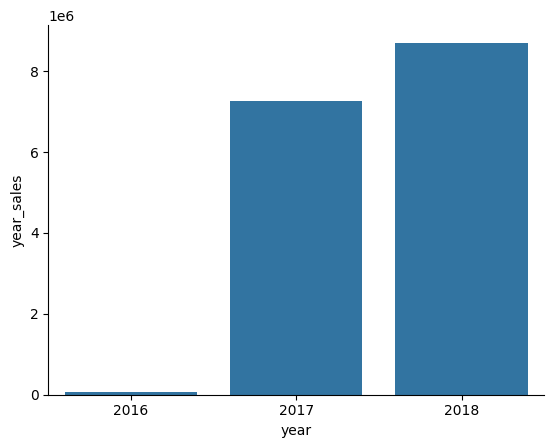

In [49]:
sns.barplot(growth_rate, x='year', y='year_sales')
sns.despine()

Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [50]:
query = ''' WITH cte1 AS (
                SELECT
                    customer_id,
                    MIN(TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS')) AS first_order
                FROM orders
                GROUP BY customer_id
            )
	        SELECT
		        cte1.customer_id,
		        COUNT(orders.order_purchase_timestamp) AS next_orders
	        FROM cte1
	        JOIN orders
		        ON cte1.customer_id = orders.customer_id
		        AND TO_TIMESTAMP(orders.order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS') > cte1.first_order
		        AND TO_TIMESTAMP(orders.order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS') < cte1.first_order + INTERVAL '6 months'
	        GROUP BY cte1.customer_id '''
cur.execute(query)
data = cur.fetchall()

In [51]:
data

[]

Identify the top 3 customers who spent the most money in each year.

In [52]:
query = ''' WITH cte1 AS (
    			SELECT
        			customers.customer_id,
        			TO_DATE(EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'))::TEXT || '-01-01', 'YYYY-MM-DD') AS year_start,
        			SUM(payment_value) AS payments
    			FROM customers
    			JOIN orders
        			ON customers.customer_id = orders.customer_id
    			JOIN payments
        			ON orders.order_id = payments.order_id
    			GROUP BY customers.customer_id, TO_DATE(EXTRACT(YEAR FROM TO_TIMESTAMP(order_purchase_timestamp, 'YYYY-MM-DD HH24:MI:SS'))::TEXT || '-01-01', 'YYYY-MM-DD')
    			ORDER BY customers.customer_id
			),
			cte2 AS (
    			SELECT
        			customer_id,
        			year_start,
        			payments,
        			DENSE_RANK() OVER (PARTITION BY year_start ORDER BY payments DESC) AS rnk
    			FROM cte1
			)
			SELECT
    			*
			FROM cte2
			WHERE rnk <= 3 '''
cur.execute(query)
data = cur.fetchall()

In [53]:
top_customers = pd.DataFrame(data, columns = ['customer_id', 'years', 'total_spend', 'rnk'])
top_customers

,customer_id,years,total_spend,rnk
0,a9dc96b027d1252bbac0a9b72d837fc6,2016-01-01,1423.55,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016-01-01,1400.74,2
2,4a06381959b6670756de02e07b83815f,2016-01-01,1227.78,3
3,1617b1357756262bfa56ab541c47bc16,2017-01-01,13664.08,1
4,c6e2731c5b391845f6800c97401a43a9,2017-01-01,6929.31,2
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017-01-01,6726.66,3
6,ec5b2ba62e574342386871631fafd3fc,2018-01-01,7274.88,1
7,f48d464a0baaea338cb25f816991ab1f,2018-01-01,6922.21,2
8,e0a2412720e9ea4f26c1ac985f6a7358,2018-01-01,4809.44,3


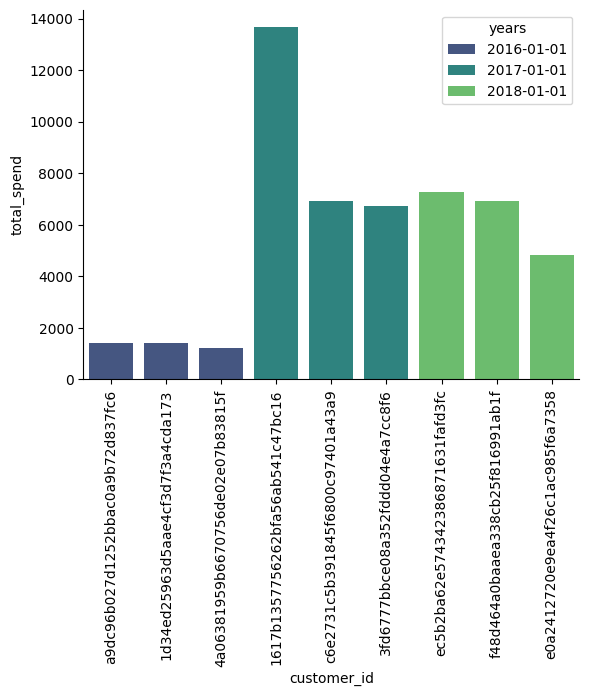

In [54]:
sns.barplot(top_customers, x='customer_id', y='total_spend', hue='years', palette='viridis')
plt.xticks(rotation=90)
sns.despine()
plt.show()